In [1]:
print(f"test - 1, 2, 3")

test - 1, 2, 3


In [2]:
# !pip install brainglobe-atlasapi tqdm pandas opencv-python -q
# !pip install matplotlib -q

import numpy as np
import pandas as pd
import cv2
# import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from brainglobe_atlasapi.bg_atlas import BrainGlobeAtlas


In [3]:
BASE_DIR = Path("./project_data")
RAW_ATLAS_DIR = BASE_DIR / "raw_atlas_slices"
SYNTHETIC_TEST_DIR = BASE_DIR / "test_synthetic"
REAL_TEST_DIR = BASE_DIR / "test_real"

RAW_ATLAS_DIR.mkdir(parents=True, exist_ok=True)
(SYNTHETIC_TEST_DIR / "images").mkdir(parents=True, exist_ok=True)
REAL_TEST_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
import matplotlib
print(matplotlib.__version__)

3.10.7


Output()

image download success


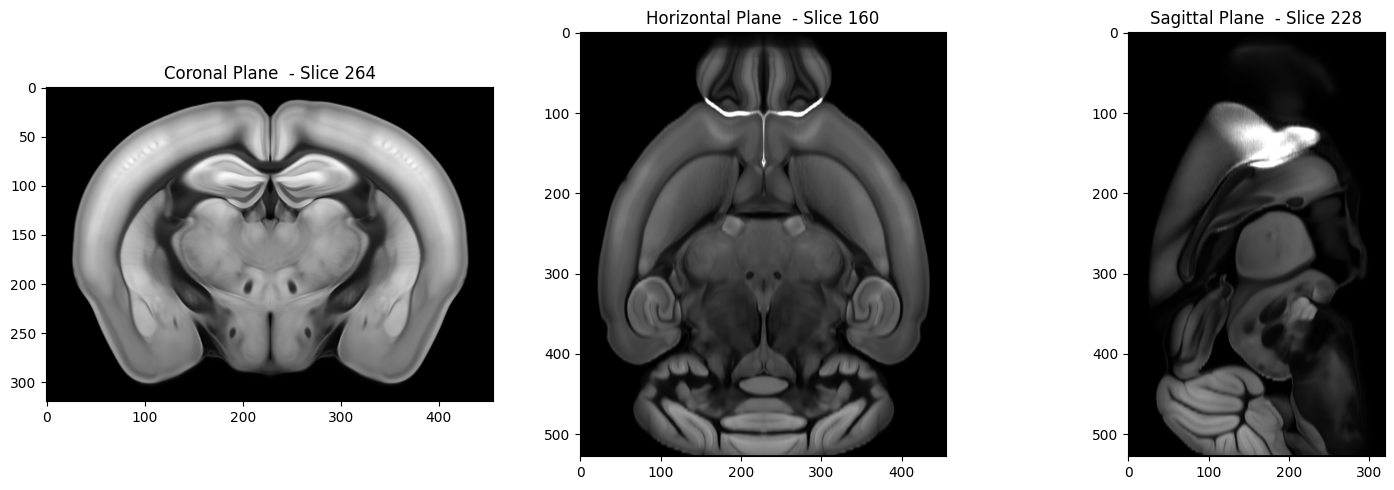

In [5]:
import matplotlib.pyplot as plt

try:
    atlas = BrainGlobeAtlas("allen_mouse_25um")
    print("image download success")
except Exception as e:
    print(f"image download fail: {e}")



if 'atlas' in locals():
    reference_volume = atlas.reference #get the size of the 3d brain model
    
    # get the index of 3 central slides of 3 directions
    coronal_idx = reference_volume.shape[0] // 2
    sagittal_idx = reference_volume.shape[2] // 2
    horizontal_idx = reference_volume.shape[1] // 2
    
    # draw
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(reference_volume[coronal_idx, :, :], cmap='gray')
    axes[0].set_title(f'Coronal Plane  - Slice {coronal_idx}')
    
    axes[1].imshow(reference_volume[:, horizontal_idx, :], cmap='gray')
    axes[1].set_title(f'Horizontal Plane  - Slice {horizontal_idx}')

    axes[2].imshow(reference_volume[:, :, sagittal_idx], cmap='gray')
    axes[2].set_title(f'Sagittal Plane  - Slice {sagittal_idx}')
    
    plt.tight_layout()
    plt.show()

In [6]:
planes_config = {
    "coronal":    {"axis": 0, "step": 4},
    "horizontal": {"axis": 1, "step": 8},
    "sagittal":   {"axis": 2, "step": 10},
}

total_slices_saved = 0

if 'atlas' in locals():
    for plane_name, config in planes_config.items():
        axis = config['axis']
        step = config['step']
        num_slices = atlas.reference.shape[axis]
        
        print(f"\n handling {plane_name} plain...")
        
        # use tqdm to show progress bar
        for i in tqdm(range(0, num_slices, step)):
            # extract slides accroding to 3 axis
            if axis == 0:
                slice_2d = atlas.reference[i, :, :]
            elif axis == 1:
                slice_2d = atlas.reference[:, i, :]
            else: # axis == 2
                slice_2d = atlas.reference[:, :, i]

            # make the image type into 8units
            slice_norm = cv2.normalize(slice_2d, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            
            # define path and file name for saving
            filename = f"{plane_name}_slice_{i:03d}.png"
            filepath = RAW_ATLAS_DIR / filename
            
            # save image
            cv2.imwrite(str(filepath), slice_norm)
            total_slices_saved += 1

print(f"\n all done, totally saved {total_slices_saved} slides.")


 handling coronal plain...


  0%|          | 0/132 [00:00<?, ?it/s]


 handling horizontal plain...


  0%|          | 0/40 [00:00<?, ?it/s]


 handling sagittal plain...


  0%|          | 0/46 [00:00<?, ?it/s]


 all done, totally saved 218 slides.


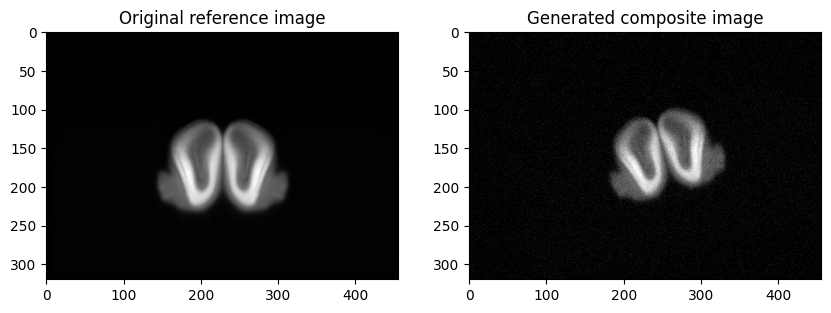

In [7]:
def create_synthetic_image(base_image, rotation, scale, tx, ty, noise_sigma):
    """
    apply transforms to make moving image for testing
    """
    h, w = base_image.shape
    center = (w // 2, h // 2)

    # 1. creat scaling and rotation matrix 
    M_rot_scale = cv2.getRotationMatrix2D(center, rotation, scale)
    
    # 2. apply translation
    M_rot_scale[0, 2] += tx
    M_rot_scale[1, 2] += ty

    # 3. Apply affine transform
    transformed_image = cv2.warpAffine(base_image, M_rot_scale, (w, h),
                                       borderMode=cv2.BORDER_CONSTANT,
                                       borderValue=0) # Fill the black background

    # 4. Add Gaussian noise
    if noise_sigma > 0:
        noise = np.random.normal(0, noise_sigma, transformed_image.shape).astype(np.float32)
        noisy_image_float = cv2.add(transformed_image.astype(np.float32), noise)
        # Crop the pixel values back to the 0-255 range
        final_image = np.clip(noisy_image_float, 0, 255).astype(np.uint8)
    else:
        final_image = transformed_image
        
    return final_image

# --- for test ---
# Load a sample diagram
test_img_path = list(RAW_ATLAS_DIR.glob("coronal*.png"))[5]
test_img = cv2.imread(str(test_img_path), cv2.IMREAD_GRAYSCALE)

# Apply transformations
synthetic_example = create_synthetic_image(test_img, rotation=15, scale=0.9, tx=20, ty=-15, noise_sigma=10)

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title("Original reference image")
axes[1].imshow(synthetic_example, cmap='gray')
axes[1].set_title("Generated composite image")
plt.show()

In [8]:
# --- Define parameter space for the synthetic test set ---
# Reference document: Dataset 1: Synthetic Ground Truth (n=120 images)
ROTATIONS = [-30, 0, 30]  # 3 levels
SCALES = [0.9, 1.0, 1.1]   # 3 levels
NOISES = [0, 10]          # 2 levels
# To get 120 test cases, we would need 120 / (3*3*2) ~= 7 base images
# The document says 40, so we'll follow that to generate 40 * 3 * 3 * 2 = 720 cases for more thoroughness
N_BASE_IMAGES = 40
# We will set the translation to a random value to make it more challenging
TRANSLATION_RANGE = (-25, 25)

# --- Start generation ---
print(f"Starting to generate {N_BASE_IMAGES * len(ROTATIONS) * len(SCALES) * len(NOISES)} synthetic test images...")

# 1. Randomly select N base reference images
all_reference_slices = list(RAW_ATLAS_DIR.glob("*.png"))
if len(all_reference_slices) < N_BASE_IMAGES:
    print(f"Warning: The number of original slices ({len(all_reference_slices)}) is less than the desired number of base images ({N_BASE_IMAGES}). All available slices will be used.")
    N_BASE_IMAGES = len(all_reference_slices)

base_image_paths = np.random.choice(all_reference_slices, N_BASE_IMAGES, replace=False)

ground_truth_data = []
image_counter = 0

# Use tqdm to display total progress
with tqdm(total=len(base_image_paths) * len(ROTATIONS) * len(SCALES) * len(NOISES)) as pbar:
    for base_path in base_image_paths:
        base_img = cv2.imread(str(base_path), cv2.IMREAD_GRAYSCALE)
        for rot in ROTATIONS:
            for scale in SCALES:
                for noise in NOISES:
                    # Generate random translation
                    tx = np.random.randint(TRANSLATION_RANGE[0], TRANSLATION_RANGE[1])
                    ty = np.random.randint(TRANSLATION_RANGE[0], TRANSLATION_RANGE[1])

                    # Create the synthetic image
                    synthetic_img = create_synthetic_image(base_img, rot, scale, tx, ty, noise)

                    # Save the image
                    synthetic_filename = f"synthetic_{image_counter:04d}.png"
                    synthetic_filepath = SYNTHETIC_TEST_DIR / "images" / synthetic_filename
                    cv2.imwrite(str(synthetic_filepath), synthetic_img)

                    # Record the Ground Truth
                    ground_truth_data.append({
                        "synthetic_file": synthetic_filename,
                        "source_file": base_path.name,
                        "rotation": rot,
                        "scale": scale,
                        "translation_x": tx,
                        "translation_y": ty,
                        "noise_sigma": noise
                    })
                    image_counter += 1
                    pbar.update(1)

# --- Save Ground Truth to a CSV file ---
ground_truth_df = pd.DataFrame(ground_truth_data)
csv_path = SYNTHETIC_TEST_DIR / "ground_truth.csv"
ground_truth_df.to_csv(csv_path, index=False)

print(f"\nSynthetic dataset generation complete!")
print(f"Total of {image_counter} images were created.")
print(f"Ground Truth file saved to: {csv_path}")
print("\nGround Truth file preview:")
print(ground_truth_df.head())

Starting to generate 720 synthetic test images...


  0%|          | 0/720 [00:00<?, ?it/s]


Synthetic dataset generation complete!
Total of 720 images were created.
Ground Truth file saved to: project_data\test_synthetic\ground_truth.csv

Ground Truth file preview:
       synthetic_file             source_file  rotation  scale  translation_x  \
0  synthetic_0000.png  sagittal_slice_100.png       -30    0.9            -14   
1  synthetic_0001.png  sagittal_slice_100.png       -30    0.9              4   
2  synthetic_0002.png  sagittal_slice_100.png       -30    1.0             -4   
3  synthetic_0003.png  sagittal_slice_100.png       -30    1.0            -21   
4  synthetic_0004.png  sagittal_slice_100.png       -30    1.1              9   

   translation_y  noise_sigma  
0            -19            0  
1             -1           10  
2             21            0  
3             23           10  
4             21            0  
